In [19]:
import numpy as np
from itertools import accumulate
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from icecream import ic

Import the libraries

In [20]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.3 
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [21]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

In [22]:
def valid(solution):
    """Controlla se la soluzione è valida (copre tutto l'universo)."""
    return np.all(np.sum(SETS[solution], axis=0) > 0)

def cost(solution):
    """Calcola il costo di una soluzione."""    
    return COSTS[solution].sum()

In [23]:
def satisfied_count(solution):
    """Restituisce il numero di elementi nell'universo che sono coperti dai set selezionati."""
    covered_elements = np.sum(SETS[solution], axis=0) > 0
    return np.sum(covered_elements)


This function is used to count the number of elements covered by the current solution.

In [24]:
def weighted_mutation(solution, strength=0.3):
    """Effettua la mutazione sulla soluzione con probabilità basata sui costi."""
    inverted_costs = 1 / COSTS
    probabilities = inverted_costs / inverted_costs.sum()
    mask = rng.random(NUM_SETS) < strength * probabilities
    if not np.any(mask):
        selected_set = rng.choice(NUM_SETS, p=probabilities)
        mask[selected_set] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

With this code we aim at tweak the solution depending the cost of the set: sets with lower cost will be tweaked with more probability.

Also, this function takes into account the "strength" of the mutation in order to be able to "perturbate" the current solution with a different strength depending on the provided parameter. The XOR operation is used to compute the "mutation".

Notice that this function can also provide an invalid solution.

In [25]:
def fitness(solution: np.ndarray):
    """Restituisce la fitness di una soluzione, bilanciando costo e copertura."""    
    coverage = satisfied_count(solution)
    cost_value = -1 * cost(solution)
    return (coverage, cost_value)

The fitness landscape takes into account the "validity" of the solution and the cost of the same solution. For the first one we avoid using a step function (valid/invalid) so that we can be more precise about the number of constraints we are violating.
The cost is inverted and the function returns a tuple of the 2 elements.

#Simulated anneling

In [26]:
def simulated_annealing_accept(new_fitness, current_fitness, temperature):
    """Accetta una nuova soluzione con probabilità basata sulla temperatura."""
    if new_fitness > current_fitness:
        return True
    else:
        delta_fitness = (current_fitness[1] - new_fitness[1]) / temperature
        #per evitare l'overflow andiamo a limitare la variazione:
        delta_fitness = np.clip(delta_fitness, -500, 500)
        return np.exp(delta_fitness) > rng.random()

ic| float(fitness(solution)[1]): -6680470.890622224
100%|██████████| 1000/1000 [00:14<00:00, 66.94it/s]
ic| float(fitness(solution)[1]): -3366414.2613174254


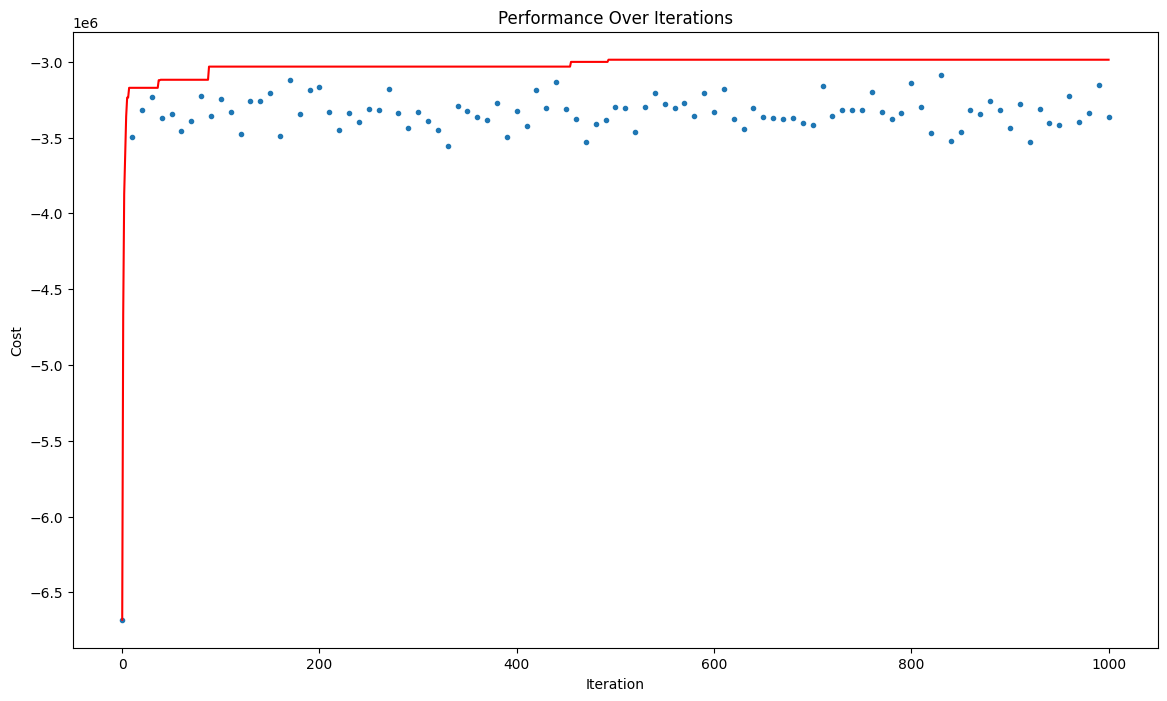

In [27]:

def multiple_mutation(solution, strength=0.3):
    mask=rng.random(NUM_SETS)<strength
    #verifico se la mask e tutta di zeri:
    if not np.any(mask):
	    #devo mettere almeno un uno:
	    #mask[rng.random.eandint(NUM_SETS)]=True
        mask[rng.integers(NUM_SETS)] = True
    new_solution=np.logical_xor(solution, mask)
    return new_solution


ITERATIONS = 1000
solution= rng.random(NUM_SETS)<1
history = [float(fitness(solution)[1])]

ic(float(fitness(solution)[1]))

for steps in tqdm(range(ITERATIONS)):
    new_solution = multiple_mutation(solution)
    new_fitness = fitness(new_solution)
    history.append(float(new_fitness[1]))

    temperature = 1.0 * (0.01 / 1.0) ** (steps / ITERATIONS)  # Vado a ridurew la temperatura

    if simulated_annealing_accept(new_fitness, fitness(solution), temperature):
        solution = new_solution
        
ic(float(fitness(solution)[1]))
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
plt.scatter(range(0, len(history), 10), history[::10], marker=".")
plt.title('Performance Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

#With self adaptive strength parameter

100%|██████████| 276/276 [00:02<00:00, 121.06it/s]

ris finale -2783556.237738256


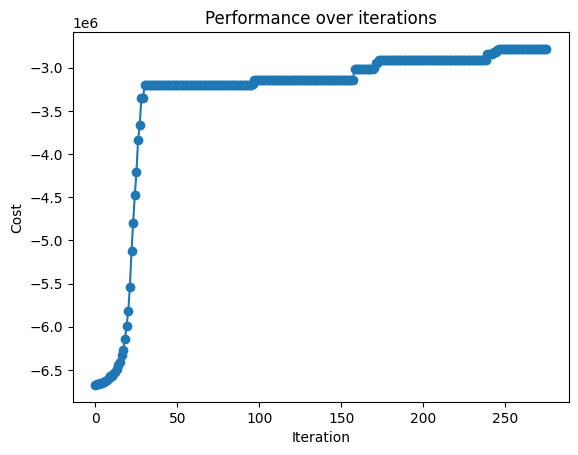

In [28]:
# Punto di partenza:
solution= rng.random(NUM_SETS)<1
history = []

buffer = []
BUF_LENGTH = int(int(DENSITY*100 * np.log(UNIVERSE_SIZE)) / 7)
solution_fitness = (0, -np.inf) 

step_size = 0.1

for steps in tqdm(range(int(DENSITY*100 * np.log(UNIVERSE_SIZE)))):
    if steps < int(DENSITY*100 * np.log(UNIVERSE_SIZE)) * 0.2:
        new_solution = weighted_mutation(solution, strength=step_size * 4) 
    else:
        new_solution = weighted_mutation(solution, strength=step_size)

    new_fitness = fitness(new_solution)
    
    buffer.append(new_fitness > solution_fitness)
    
    # Se trovo una soluzione migliore, aggiorno
    if new_fitness > solution_fitness:
        solution_fitness = new_fitness
        solution = new_solution

    history.append(float(solution_fitness[1]))

    if len(buffer) > BUF_LENGTH:
        buffer.pop(0)

    if np.sum(buffer) > 1:
        step_size = step_size + 0.3*step_size
    else:
        step_size = step_size - 0.3*step_size

print("ris finale", fitness(solution)[1])
plt.plot(range(0, len(history)), history, marker='o')  
plt.title("Performance over iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()
